# Open modification searching: Precursor mass differences

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns

import reader
import util

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

In [4]:
max_fdr = 0.01
bandwidth = 0.05
min_cluster_size = 5

In [5]:
filename = '../data/processed/iprg2012/brute_force/bf_oms_shifted.mztab'
psms = util.filter_group_fdr(reader.read_mztab_psms(filename), max_fdr, 0.1, 'Da')

/Users/Wout/.conda/envs/ann-solo/lib/python3.6/site-packages/pyteomics/auxiliary.py:661: RuntimeWarning: divide by zero encountered in true_divide
  q = tfalse / (ind - cumsum) / ratio


In [6]:
# find mass difference clusters
psms['mass_diff'] = (
    (psms['exp_mass_to_charge'] - psms['calc_mass_to_charge']) * psms['charge']
)

mass_diffs, counts = np.unique(
    np.around(psms['mass_diff'], 0), return_counts=True)

In [7]:
mask = np.where(counts >= 10)[0]
mass_diffs, counts = mass_diffs[mask], counts[mask]

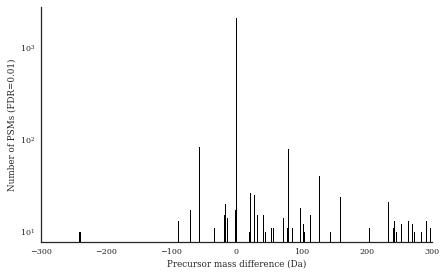

In [8]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

ax.bar(mass_diffs, counts, width=1, log=True, color='black')

ax.set_xlabel('Precursor mass difference (Da)')
ax.set_ylabel('Number of PSMs (FDR={})'.format(max_fdr))

ax.set_xlim((-300, 300))

# set tick labels at nice positions
ax.xaxis.set_major_locator(mticker.MultipleLocator(100))

sns.despine()

plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()